In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.feature_selection import do_forward_selection_cv, select_N_standard_error_ind

In [2]:
# '\s+' tells pandas to use any spaces as the delimiter instead of ,
train_df = pd.read_csv("../data/train.2024.04.16.csv")
feature_col_names = np.array(['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13'])

In [3]:
all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
X = all_feats_df[feature_col_names].to_numpy()
y = all_feats_df["y"].to_numpy()

In [4]:
print(X.shape)
q1, q3  = np.percentile(X, [25, 75], axis=0)
IQR = q3 - q1
lower_fence = q1 - IQR*3.0
upper_fence = q3 + IQR*3.0
drop_inds = np.unique(np.concatenate([np.unique(np.where(X < lower_fence)[0]), 
                                      np.unique(np.where(X > upper_fence)[0])]))
keep_inds = np.delete(np.arange(0, X.shape[0]), drop_inds)
X = X[keep_inds, :]
y = y[keep_inds]
print(X.shape)

(757, 13)
(752, 13)


In [7]:
np.unique(y, return_counts=True)[1]/y.shape[0]

array([0.14893617, 0.7393617 , 0.11170213])

In [5]:
model = LDA()
pipeline = Pipeline([('scaler', StandardScaler()), ('m', model)])
scoring_method ='f1_macro'
larger_score_is_better = True
cv_random_state=2652124

In [6]:
def compute_example_frac(full_df, feat_ids, feat_col_names, starting_feat_ids=None):
    n_examples = full_df.shape[0]
    fracs = []
    start_frac = 1.0
    feats = []
    if starting_feat_ids is not None:
        feats = list(feat_col_names[starting_feat_ids])
        start_frac = full_df[np.all(~np.isnan(full_df[feats]), axis=1)].shape[0]/n_examples
    fracs.append(start_frac)

    for feat_ind in feat_ids:
        feats.append(feat_col_names[feat_ind])
        frac = full_df[np.all(~np.isnan(full_df[feats]), axis=1)].shape[0]/n_examples
        fracs.append(frac)
    return fracs

In [7]:
def plot_sequential_selected_feature_scores(ids_scores, 
                                            feature_names, 
                                            base_set_name="None",
                                            title="CV $R^2$ Ranges for Selected Features",
                                            savefigname=None,
                                            ylim=[0, 1.05],
                                            ex_frac=None,
                                            legend_loc='lower right',
                                            xlabel_rotation=90,
                                            ylabel1="CV F1 Score (Macro)",
                                            ylabel2='Fraction of Training Examples',
                                            xlabel="Added Feature",
                                            figsize=(4, 3)):
    feat_plot_names = np.concatenate([[base_set_name], feature_names])
    x = np.arange(ids_scores.shape[0])
    fig, ax = plt.subplots(1, constrained_layout=True, figsize=figsize)
    ax.fill_between(x, ids_scores[:, 1], ids_scores[:, 2], color='gray', 
                     alpha=0.5, label='CV range')
    ax.plot(x, ids_scores[:, 0], color='k', marker='x', label='CV mean')
    ax.set_xticks(x, feat_plot_names, rotation=xlabel_rotation)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel1)
    ax.legend(loc=legend_loc)
    ax.set_title(title)
    ax.grid(axis='y')
    ax.set_ylim(ylim)

    if ex_frac is not None:
        ax2 = ax.twinx()
        ax2.plot(range(len(ex_frac)), ex_frac, color='r')
        ax2.set_ylim([0, 1.05])
        ax2.set_ylabel(ylabel2, color='r')  # we already handled the x-label with ax1
        ax2.tick_params(axis='y', labelcolor='r')

    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)
    print(fig.get_size_inches())

In [8]:
cv_outer = RepeatedStratifiedKFold(n_splits=10, 
                        n_repeats=2, 
                        random_state=cv_random_state)

In [9]:
feature_ids = np.arange(13)
feature_ids


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

0 0.4473719617337516
1 0.43282739069772835
2 0.37080307452200173
3 0.5080142840300013
4 0.4369589262605774
5 0.5921883046868949
6 0.584950871231895
7 0.3881569106115511
8 0.633814633411514
9 0.5149189760953791
10 0.4950434334795594
11 0.621366525857046
12 0.6749153024931497
[12  0] 0.7756356006404413
[12  1] 0.6837718665695386
[12  2] 0.6733598059895877
[12  3] 0.7504565986713562
[12  4] 0.7140057472177859
[12  5] 0.7389590698044064
[12  6] 0.777287433500071
[12  7] 0.7217879986501149
[12  8] 0.7447175248829899
[12  9] 0.7514146361456486
[12 10] 0.7588977657654351
[12 11] 0.6711690525652132
[12  6  0] 0.8657418948139682
[12  6  1] 0.8379351200913356
[12  6  2] 0.8278403655192254
[12  6  3] 0.7956826263247002
[12  6  4] 0.8094352493997423
[12  6  5] 0.7931542792988536
[12  6  7] 0.782136625808237
[12  6  8] 0.8152435229476845
[12  6  9] 0.8028672437104651
[12  6 10] 0.8006993630416904
[12  6 11] 0.7934522011077503
[12  6  0  1] 0.888755642879878
[12  6  0  2] 0.8976921135183801
[12  6  

[4. 3.]


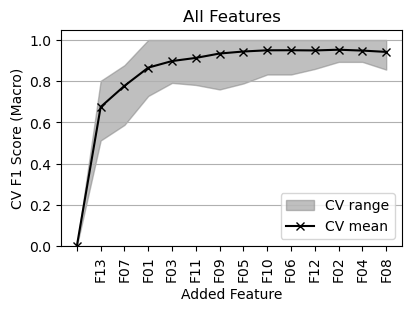

In [11]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="All Features",
                                        base_set_name="",
                                        savefigname=f"../figures/sequential_{cv_random_state}.png")

[4. 3.]


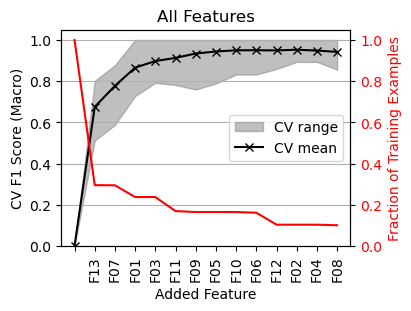

In [12]:
fracs = compute_example_frac(train_df, ids, feature_col_names)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="All Features",
                                        base_set_name="",
                                        ex_frac=fracs,
                                        legend_loc='center right',
                                        savefigname=f"../figures/sequential_{cv_random_state}_frac.png")

In [13]:
feature_ids = np.arange(13)
ex_mis_weights = np.array([0.57251845, 0.41531536, 0.58029524, 0.41531536, 0.58216828,
       0.41531536, 0.58216828, 0.20491272, 0.24145594, 0.20235696,
       0.11844404, 0.13342233, 0.23413954])
total_weights = np.array([0.46921444, 0.31868365, 0.53842887, 0.31942675, 0.54171975,
       0.31942675, 0.54171975, 0.15785563, 0.23503185, 0.22409766,
       0.19076433, 0.13089172, 0.29522293])
N_ste = 3

In [14]:
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10,
                                                    weights=total_weights,
                                                    N_ste=N_ste)

0 0.4473719617337516
1 0.43282739069772835
2 0.37080307452200173
3 0.5080142840300013
4 0.4369589262605774
5 0.5921883046868949
6 0.584950871231895
7 0.3881569106115511
8 0.633814633411514
9 0.5149189760953791
10 0.4950434334795594
11 0.621366525857046
12 0.6749153024931497
STE= 0.07879916971261217 [ 8 11 12] [0.23503185 0.13089172 0.29522293]
0
[12  0] 0.7756356006404413
[12  1] 0.6837718665695386
[12  2] 0.6733598059895877
[12  3] 0.7504565986713562
[12  4] 0.7140057472177859
[12  5] 0.7389590698044064
[12  6] 0.777287433500071
[12  7] 0.7217879986501149
[12  8] 0.7447175248829899
[12  9] 0.7514146361456486
[12 10] 0.7588977657654351
[12 11] 0.6711690525652132
STE= 0.029862209325346216 [ 0  3  6  9 10] [0.46921444 0.31942675 0.54171975 0.22409766 0.19076433]
1
[12  6  0] 0.8657418948139682
[12  6  1] 0.8379351200913356
[12  6  2] 0.8278403655192254
[12  6  3] 0.7956826263247002
[12  6  4] 0.8094352493997423
[12  6  5] 0.7931542792988536
[12  6  7] 0.782136625808237
[12  6  8] 0.81524

[4. 3.]


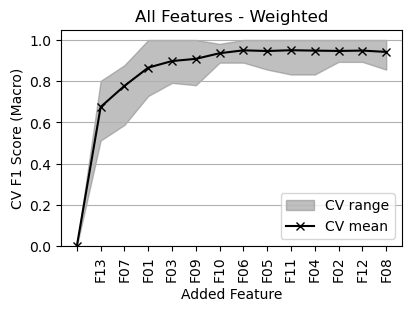

In [15]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="All Features - Weighted",
                                        base_set_name="",
                                        savefigname=f"../figures/sequential_{cv_random_state}_{N_ste}STE_totalW.png")

In [16]:
feature_act_names = np.array(["$M_L$-$M_C$", "$M_{w,P}$-$M_C$", "$M_{w,S}$-$M_C$", "$AIC_P$", "$AIC_S$",
                     "$\phi_P$", "$\phi_S$", '$P_{2-4 Hz}/ S_{2-4 Hz}$', '$P_{4-6 Hz}/ S_{4-6 Hz}$', 
                     '$P_{6-8 Hz}/ S_{6-8 Hz}$', '$P_{8-10 Hz}/ S_{8-10 Hz}$',
                     '$P_{2-4 Hz}/ P_{8-10 Hz}$', '$S_{2-4 Hz}/ S_{8-10 Hz}$'])

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_4024737/1816552939.py:2: SyntaxWarning: invalid escape sequence '\p'
  "$\phi_P$", "$\phi_S$", '$P_{2-4 Hz}/ S_{2-4 Hz}$', '$P_{4-6 Hz}/ S_{4-6 Hz}$',
/tmp/ipykernel_4024737/1816552939.py:2: SyntaxWarning: invalid escape sequence '\p'
  "$\phi_P$", "$\phi_S$", '$P_{2-4 Hz}/ S_{2-4 Hz}$', '$P_{4-6 Hz}/ S_{4-6 Hz}$',


In [17]:
feature_act_names = np.array(["$M_L$-$M_C$", "$M_{w,P}$-$M_C$", "$M_{w,S}$-$M_C$", "$AIC_P$", "$AIC_S$",
                     "$\phi_P$", "$\phi_S$", '$P/S_{2-4 Hz}$', '$P/S_{4-6 Hz}$', 
                     '$P/S_{6-8 Hz}$', '$P/S_{8-10 Hz}$',
                     '$LP/SP_P$', '$LP/SP_S$'])

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_4024737/2534025563.py:2: SyntaxWarning: invalid escape sequence '\p'
  "$\phi_P$", "$\phi_S$", '$P/S_{2-4 Hz}$', '$P/S_{4-6 Hz}$',
/tmp/ipykernel_4024737/2534025563.py:2: SyntaxWarning: invalid escape sequence '\p'
  "$\phi_P$", "$\phi_S$", '$P/S_{2-4 Hz}$', '$P/S_{4-6 Hz}$',


[1.0, 0.2954152823920266, 0.29448504983388707, 0.2374750830564784, 0.2374750830564784, 0.18445182724252493, 0.18046511627906978, 0.17714285714285713, 0.17714285714285713, 0.16146179401993355, 0.16146179401993355, 0.16146179401993355, 0.10325581395348837, 0.10059800664451828]
[4. 3.]


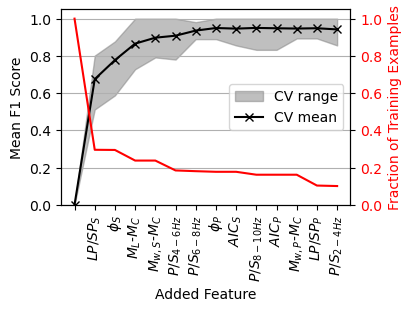

In [18]:
fracs = compute_example_frac(train_df, ids, feature_col_names)
print(fracs)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_act_names[ids],
                                        title=None,#f"Sequential Feature Selection ({N_ste} st. err.)",
                                        base_set_name="",
                                        ex_frac=fracs,
                                        legend_loc='center right',
                                        savefigname=f"../figures/sequential_{cv_random_state}_{N_ste}STE_frac_totalW.png",
                                        xlabel_rotation=90,
                                        ylabel1="Mean F1 Score")

In [19]:
most_common = [2, 4, 6]
feature_ids = np.delete(np.arange(X.shape[1]), [2, 4, 6])
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10,
                                                    required_feature_ids=[2, 4, 6],
                                                    )

[2, 4, 6] 0.7703944687432618
[2 4 6 0] 0.8691441444621459
[2 4 6 1] 0.7580779438758989
[2 4 6 3] 0.764413262308596
[2 4 6 5] 0.770728978508213
[2 4 6 7] 0.7761683724637936
[2 4 6 8] 0.8056213915883701
[2 4 6 9] 0.7925185804795206
[ 2  4  6 10] 0.7947141087205274
[ 2  4  6 11] 0.8468305991667145
[ 2  4  6 12] 0.8630636145554036
[2 4 6 0 1] 0.8530493614278545
[2 4 6 0 3] 0.862186008825266
[2 4 6 0 5] 0.8652090832399331
[2 4 6 0 7] 0.8673423859218439
[2 4 6 0 8] 0.8614383496964318
[2 4 6 0 9] 0.8782009191105257
[ 2  4  6  0 10] 0.8792243233205062
[ 2  4  6  0 11] 0.8901515961937958
[ 2  4  6  0 12] 0.9063626824295599
[ 2  4  6  0 12  1] 0.8850001222986595
[ 2  4  6  0 12  3] 0.9012151187465272
[ 2  4  6  0 12  5] 0.911745538401156
[ 2  4  6  0 12  7] 0.9128517024749133
[ 2  4  6  0 12  8] 0.9094400565947321
[ 2  4  6  0 12  9] 0.9114060690832465
[ 2  4  6  0 12 10] 0.9044973442984616
[ 2  4  6  0 12 11] 0.899801114675537
[ 2  4  6  0 12  7  1] 0.8878478626025403
[ 2  4  6  0 12  7  3] 0.8

[4. 3.]


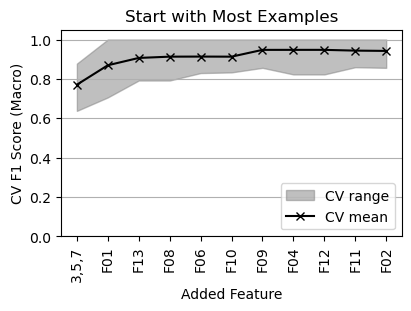

In [20]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids[3:]],
                                        base_set_name="3,5,7",
                                        title="Start with Most Examples")

[4. 3.]


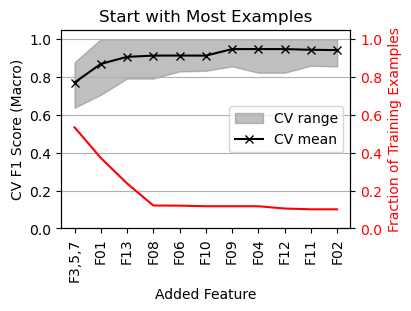

In [21]:
fracs = compute_example_frac(train_df, ids[3:], feature_col_names, starting_feat_ids=most_common)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids[3:]],
                                        base_set_name="F3,5,7",
                                        title="Start with Most Examples",
                                        ex_frac=fracs,
                                        legend_loc='center right',
                                        savefigname=f"../figures/sequential_{cv_random_state}_req357_all_frac.png")

total_weights = np.array([0.46921444, 0.31868365, 0.53842887, 0.31942675, 0.54171975,
       0.31942675, 0.54171975, 0.15785563, 0.23503185, 0.22409766,
       0.19076433, 0.13089172, 0.29522293])

In [22]:
most_common = [2, 4, 6]
feature_ids = np.delete(np.arange(X.shape[1]), [2, 4, 6])
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10,
                                                    required_feature_ids=[2, 4, 6],
                                                    weights=total_weights,
                                                    N_ste=N_ste)

[2, 4, 6] 0.7703944687432618
[2 4 6 0] 0.8691441444621459
[2 4 6 1] 0.7580779438758989
[2 4 6 3] 0.764413262308596
[2 4 6 5] 0.770728978508213
[2 4 6 7] 0.7761683724637936
[2 4 6 8] 0.8056213915883701
[2 4 6 9] 0.7925185804795206
[ 2  4  6 10] 0.7947141087205274
[ 2  4  6 11] 0.8468305991667145
[ 2  4  6 12] 0.8630636145554036
STE= 0.03716217997133907 [ 0 11 12] [0.46921444 0.13089172 0.29522293]
0
[2 4 6 0 1] 0.8530493614278545
[2 4 6 0 3] 0.862186008825266
[2 4 6 0 5] 0.8652090832399331
[2 4 6 0 7] 0.8673423859218439
[2 4 6 0 8] 0.8614383496964318
[2 4 6 0 9] 0.8782009191105257
[ 2  4  6  0 10] 0.8792243233205062
[ 2  4  6  0 11] 0.8901515961937958
[ 2  4  6  0 12] 0.9063626824295599
STE= 0.014866620620275477 [12] [0.29522293]
1
[ 2  4  6  0 12  1] 0.8850001222986595
[ 2  4  6  0 12  3] 0.9012151187465272
[ 2  4  6  0 12  5] 0.911745538401156
[ 2  4  6  0 12  7] 0.9128517024749133
[ 2  4  6  0 12  8] 0.9094400565947321
[ 2  4  6  0 12  9] 0.9114060690832465
[ 2  4  6  0 12 10] 0.9044

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3909931/4122254962.py:5: SyntaxWarning: invalid escape sequence '\p'
  base_set_name="[$M_{w,S}$-$M_C$, \n $AIC_S$, $\phi_S$]",


[0.5340863787375415, 0.37209302325581395, 0.2374750830564784, 0.19787375415282393, 0.18112956810631228, 0.17714285714285713, 0.16146179401993355, 0.16146179401993355, 0.16146179401993355, 0.10325581395348837, 0.10059800664451828]
[4. 3.]


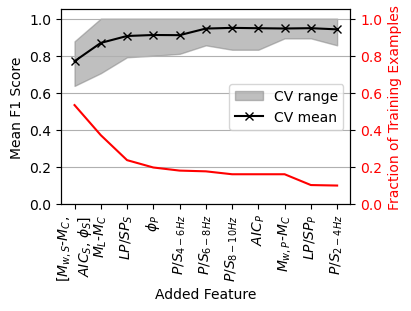

In [27]:
fracs = compute_example_frac(train_df, ids[3:], feature_col_names, starting_feat_ids=most_common)
print(fracs)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_act_names[ids[3:]],
                                        base_set_name="[$M_{w,S}$-$M_C$, \n $AIC_S$, $\phi_S$]",
                                        ex_frac=fracs,
                                        legend_loc='center right',
                                        savefigname=f"../figures/sequential_{cv_random_state}_req357_all_frac_{N_ste}STE.png",
                                        title=None,#f"Sequential Feature Selection ({N_ste} st. err.)",
                                        xlabel_rotation=90,
                                        ylabel1="Mean F1 Score")


In [19]:
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    [0, 2, 6], 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

0 0.4473719617337516
2 0.37080307452200173
6 0.584950871231895
[6 0] 0.828287066133977
[6 2] 0.7326603946836202
[6 0 2] 0.9084885012760434


In [21]:
fracs = compute_example_frac(train_df, ids, feature_col_names)
fracs

[1.0, 0.5372757475083056, 0.37209302325581395, 0.37209302325581395]

[4. 3.]


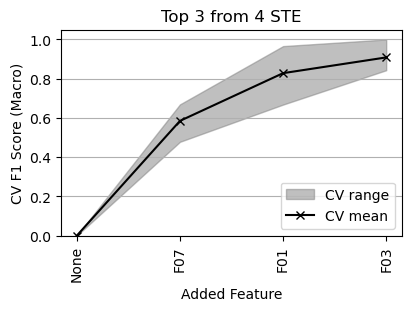

In [20]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Top 3 from 4 STE")

In [ ]:
feature_ids = np.delete(np.arange(X.shape[1]), [0, 6, 8, 9, 12])
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

In [ ]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Remove LDA most important")

In [ ]:
feature_ids = [0, 1, 2, 6 ,8, 9, 12]
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

In [ ]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="LDA most important")

In [28]:
feature_ids = [0, 6 ,8, 9, 12]
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

0 0.4473719617337516
6 0.584950871231895
8 0.633814633411514
9 0.5149189760953791
12 0.6749153024931497
[12  0] 0.7756356006404413
[12  6] 0.777287433500071
[12  8] 0.7447175248829899
[12  9] 0.7514146361456486
[12  6  0] 0.8657418948139682
[12  6  8] 0.8152435229476845
[12  6  9] 0.8028672437104651
[12  6  0  8] 0.8942495524228992
[12  6  0  9] 0.8730959783025274
[12  6  0  8  9] 0.9190410656681074


[4. 3.]


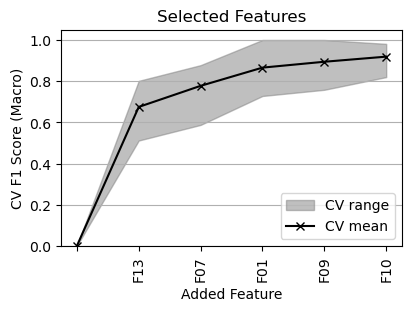

In [29]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Selected Features",
                                        base_set_name="")

[1.0, 0.2954152823920266, 0.29448504983388707, 0.2374750830564784, 0.18445182724252493, 0.18046511627906978]
[4. 3.]


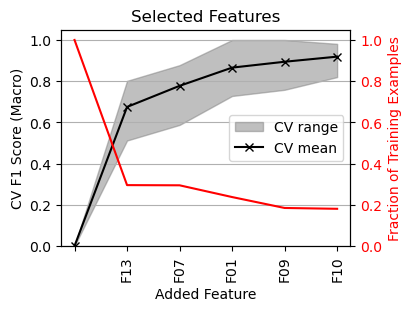

In [31]:
fracs = compute_example_frac(train_df, ids, feature_col_names)
print(fracs)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Selected Features",
                                        base_set_name="",
                                        ex_frac=fracs,
                                        legend_loc='center right')

In [32]:
feature_ids = [0, 3 ,5, 8, 12]
ids, ids_scores, all_scores = do_forward_selection_cv(X,
                                                    y,
                                                    feature_ids, 
                                                    cv_outer,
                                                    pipeline,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

0 0.4473719617337516
3 0.5080142840300013
5 0.5921883046868949
8 0.633814633411514
12 0.6749153024931497
[12  0] 0.7756356006404413
[12  3] 0.7504565986713562
[12  5] 0.7389590698044064
[12  8] 0.7447175248829899
[12  0  3] 0.8331532282826887
[12  0  5] 0.8275560637976852
[12  0  8] 0.8463551271302787
[12  0  8  3] 0.871427301664092
[12  0  8  5] 0.886870129254625
[12  0  8  5  3] 0.8883899354933666


[4. 3.]


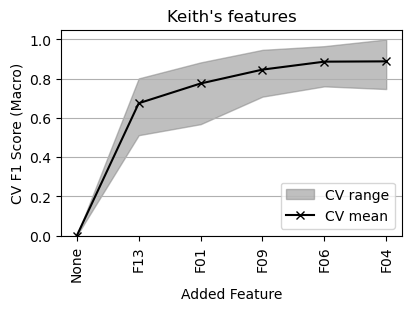

In [33]:
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Keith's features")

[1.0, 0.2954152823920266, 0.23800664451827241, 0.18458471760797343, 0.18126245847176078, 0.18126245847176078]
[4. 3.]


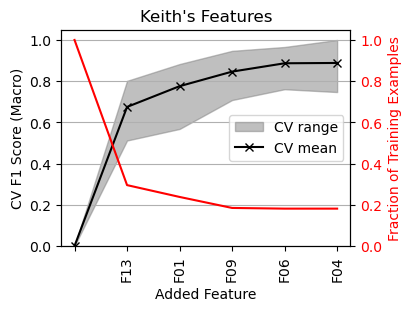

In [34]:
fracs = compute_example_frac(train_df, ids, feature_col_names)
print(fracs)
plot_sequential_selected_feature_scores(ids_scores,
                                        feature_col_names[ids],
                                        title="Keith's Features",
                                        base_set_name="",
                                        ex_frac=fracs,
                                        legend_loc='center right')